In [1]:
from config import *
from tools import *
from Unet import *

In [2]:
img_path = explore_dir("./dataset/val_images/")[1][:,np.newaxis]
mask_path = explore_dir("./dataset/TrainVal_parsing_annotations/val_segmentations/")[1][:,np.newaxis]
val_paths = np.concatenate((img_path,mask_path), axis=1)

val_dataset = np.array(Pool(processes=4).map(im_and_roi_read,val_paths)).transpose(1,0,2,3,4)
val_img, val_roi = val_dataset
val_data, val_label = separate_batches(val_img,val_roi, 100)

tf.reset_default_graph()

unet = Unet((128,128,3), (128,128,3),2)

saver = tf.train.Saver()
saver.restore(unet.sess, "./snapshot/Unet_Human_only.ckpt")

INFO:tensorflow:Restoring parameters from ./snapshot/Unet_Human_only.ckpt


In [3]:
with tqdm(total=len(val_data)) as pbar:
    pbar.set_description("[ Estimating Validation Dataset ]")
    roi_result = []
    for v in range(len(val_data)):
        result = unet.sess.run(unet.score, feed_dict={unet.x: val_data[v],unet.keep_prob: 1.0})
        result = np.argmax(result,axis=3)[:,:,:,np.newaxis]
        result = masking(result, Human_only=True)
        roi_result += list(result)
        pbar.update(1)

[ Estimating Validation Dataset ]: 100%|██████████| 100/100 [03:40<00:00,  2.12s/it]


Text(0.5,1,'Ground Truth RoI Mask')

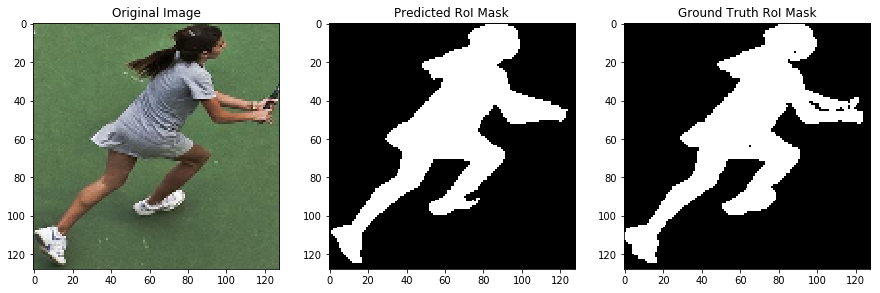

In [4]:
idx=25
fig, plot = plt.subplots(1,3)
fig.set_size_inches(15, 15)
plot[0].imshow(val_img[idx][:,:,[2,1,0]])
plot[0].set_title("Original Image")
plot[1].imshow(roi_result[idx][:,:,[2,1,0]])
plot[1].set_title("Predicted RoI Mask")
plot[2].imshow(masking(val_roi[idx][np.newaxis,:,:], Human_only=True)[0])
plot[2].set_title("Ground Truth RoI Mask")